# cGRU; Var(2); T = 1000

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_lorenz_96, simulate_var
from cgru import cGRU, train_model_ista

In [2]:
# For GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Simulate data
X_np, beta, GC = simulate_var(p=20, T=1000, lag=2)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

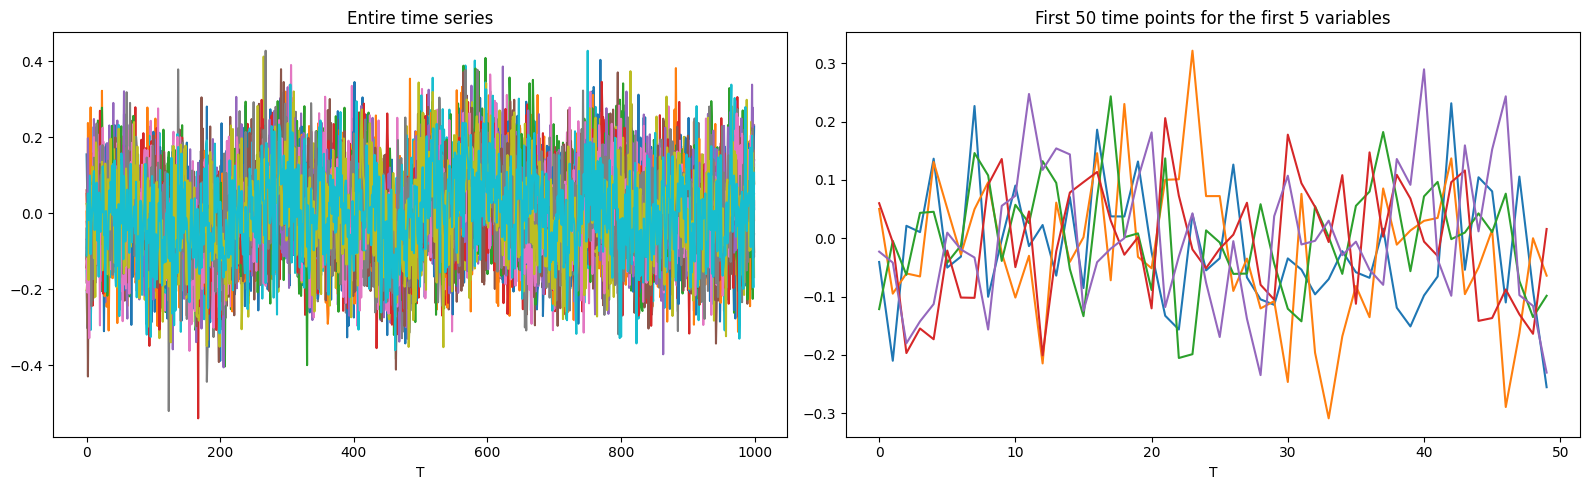

In [4]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50, :5])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points for the first 5 variables')
plt.tight_layout()

plt.show()

In [5]:
  #Set up model
  cgru = cGRU(X.shape[-1], hidden=100).to(device=device)

  # Train with ISTA
  train_loss_list = train_model_ista(cgru, X, context=10, lr=1e-1, max_iter=20000, lam=0.0009, lam_ridge=1e-2,
                   check_every=50)

  # Loss function plot
  plt.figure(figsize=(8, 5))
  train_loss_np = [loss.cpu().detach().numpy() for loss in train_loss_list]
  plt.plot(50 * np.arange(len(train_loss_np)), train_loss_np)
  plt.title('cGRU training')
  plt.ylabel('Loss')
  plt.xlabel('Training steps')
  plt.tight_layout()
  plt.show()

  # Verify learned Granger causality
  GC_est = cgru.GC().cpu().data.numpy()

  # Make figures for Granger causality matrices
  fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
  axarr[0].imshow(GC, cmap='Blues')
  axarr[0].set_title('GC actual')
  axarr[0].set_ylabel('Affected series')
  axarr[0].set_xlabel('Causal series')
  axarr[0].set_xticks([])
  axarr[0].set_yticks([])

  axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
  axarr[1].set_title('GC estimated')
  axarr[1].set_ylabel('Affected series')
  axarr[1].set_xlabel('Causal series')
  axarr[1].set_xticks([])
  axarr[1].set_yticks([])

  # Mark disagreements
  for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

  plt.show()

NameError: name 'save_dir' is not defined